<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [342]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11665403496325850667
xla_global_id: -1
]


In [343]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tf_keras

from keras import layers
from keras import models
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization
from keras.models import load_model
from tensorflow.keras.utils import to_categorical

In [344]:
num_classes = 10

In [345]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [346]:
def drow_hist(data):
  plt.figure(figsize=(8,6), dpi= 80)
  _ = plt.hist(data,
              bins=num_classes,
              stacked=True,
              density=False,
              range=(0,10),
              rwidth=0.9,
              )

In [347]:
# create validation data
val_size = 6600

x_val = x_train[-val_size:, :, :]
x_train = x_train[:-val_size, :, :]

y_val = y_train[-val_size:]
y_train = y_train[:-val_size]

In [348]:
# mirror train image
# x_train_add = np.rot90(x_train, k=1, axes=(1,2))
# x_train_add = np.transpose(x_train_add, (0, 2, 1))

In [349]:
# y_train_add = y_train.copy()

In [350]:
# # remove boots image from addition data [5, 7, 9]
# for i in [5, 7, 9]:
#     index = np.where(y_train_add == i )
#     x_train_add = np.delete(x_train_add, index , axis=0)
#     y_train_add = np.delete(y_train_add, index , axis=0)

In [351]:
# x_train_add.shape

In [352]:
# y_train_add.shape

In [353]:
# x_train = np.concatenate([
#     x_train,
#     x_train_add[:10000:, :, :]
# ])

In [354]:
# y_train = np.concatenate([
#     y_train,
#     y_train_add[:10000]
# ])

In [355]:
# drow_hist(y_train)

In [356]:
# plt.figure()
# plt.imshow(x_train[7])
# plt.colorbar()
# plt.grid(False)
# plt.show()

In [357]:
# plt.figure()
# plt.imshow(x_train_add[0])
# plt.colorbar()
# plt.grid(False)
# plt.show()

In [358]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [359]:
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(x_train[i+50000], cmap=plt.cm.binary)
#     plt.xlabel(class_names[int(y_train[i+50000])])
# plt.show()

In [360]:
# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(x_train[i], cmap=plt.cm.binary)
#     plt.xlabel(class_names[int(y_train[i])])
# plt.show()

In [361]:
w_init_tanh = initializers.glorot_normal(seed=111)
w_init_relu = initializers.HeNormal(seed=66)
# w_init_relu = initializers.HeUniform(seed=24)
b_init = initializers.Zeros()

In [362]:
def layer_relu(model, neurons, drop_out):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                       activation='relu',
                       kernel_initializer=w_init_relu,
                       bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  print(drop_out)
  return model

In [363]:
def layer_tanh(model, neurons, drop_out):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                        activation='tanh',
                        kernel_initializer=w_init_tanh,
                        bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  return model

In [364]:
model = models.Sequential()

neurons = 256
drop_out = 0.2

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(0.3))

model = layer_relu(model, neurons*1, drop_out)
model = layer_tanh(model, neurons*2, drop_out)
model = layer_relu(model, neurons*2, drop_out)
# model = layer_relu(model, neurons*2)


model.add(layers.Dense(10, activation='softmax'))

0.2
0.2


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [365]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0004,
                                      beta_1=0.9,
                                      beta_2=0.999,
                                      epsilon=1e-06
)
# optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.0005,
#                                                     rho=0.5,
#                                                     momentum=-16,
#                                                     epsilon=1e-07,
#                                                     centered=False,
#                                                     weight_decay=None,
#                                                     clipnorm=None,
#                                                     clipvalue=None,
#                                                     global_clipnorm=None,
#                                                     use_ema=False,
#                                                     ema_momentum=0.99,
#                                                     ema_overwrite_frequency=100,
#                                                     jit_compile=True,
#                                                     name='RMSprop',
# )

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [366]:
model.compile(#optimizer='adam',
              # optimizer='adamax',
              optimizer=optimizer,
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy']) # sparse_categorical_accuracy

In [367]:
# callback = callbacks.EarlyStopping(monitor='val_loss',
#                                    patience=15,
#                                    restore_best_weights=True,
#                                    )
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=60)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='categorical_accuracy', mode='max', verbose=0, save_best_only=True)


In [368]:
history = model.fit(x_train, y_train,
                    epochs=1000,
                    batch_size=128,
                    # callbacks=[callback],
                    callbacks=[mc, es],
                    verbose=1, #многословие
                    # validation_split=0.2
                    validation_data=(x_val, y_val)
                    )
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/1000
418/418 [==============================] - 14s 26ms/step - loss: 0.7552 - categorical_accuracy: 0.7334 - val_loss: 0.4379 - val_categorical_accuracy: 0.8320
Epoch 2/1000
418/418 [==============================] - 11s 27ms/step - loss: 0.5393 - categorical_accuracy: 0.8027 - val_loss: 0.3939 - val_categorical_accuracy: 0.8530
Epoch 3/1000
418/418 [==============================] - 11s 27ms/step - loss: 0.4789 - categorical_accuracy: 0.8227 - val_loss: 0.3837 - val_categorical_accuracy: 0.8589
Epoch 4/1000
418/418 [==============================] - 11s 27ms/step - loss: 0.4475 - categorical_accuracy: 0.8349 - val_loss: 0.3556 - val_categorical_accuracy: 0.8665
Epoch 5/1000
418/418 [==============================] - 11s 27ms/step - loss: 0.4242 - categorical_accuracy: 0.8423 - val_loss: 0.3476 - val_categorical_accuracy: 0.8732
Epoch 6/1000
418/418 [==============================] - 11s 26ms/step - loss: 0.4065 - categorical_accuracy: 0.8484 - val_loss: 0.3439 - val_categoric

In [369]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy']


In [370]:
result = model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 4ms/step - loss: 0.3137 - categorical_accuracy: 0.8966
[0.31371834874153137, 0.8966000080108643]


In [371]:
saved_model = load_model('best_model.h5')
result = saved_model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 4ms/step - loss: 0.3027 - categorical_accuracy: 0.9015
[0.302721232175827, 0.9014999866485596]


In [372]:
# from keras.models import load_model
# saved_model = load_model('best_model.h5')
# # _, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
# _, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
# print('Test: %.3f' % (test_acc))

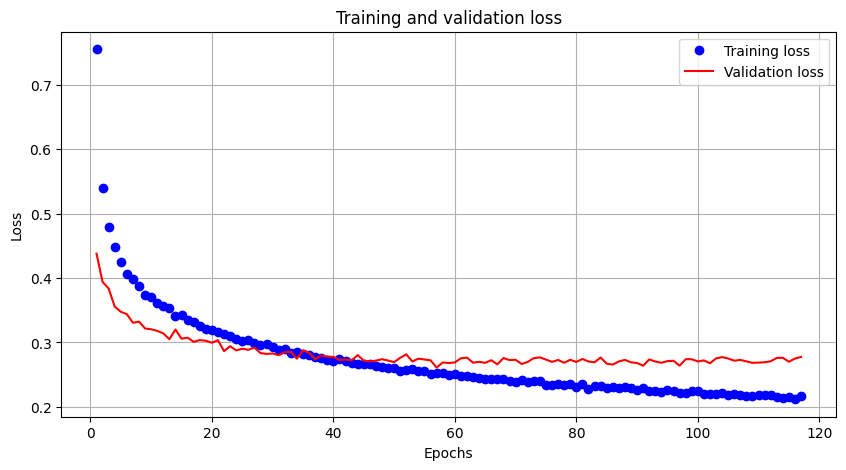

<Figure size 640x480 with 0 Axes>

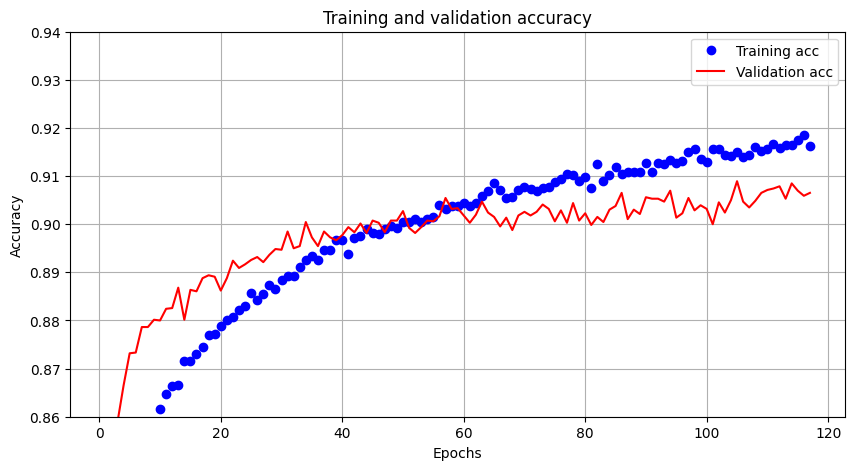

In [373]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
# plt.ylim (0.2, 0.5)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
1
plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['categorical_accuracy']
plt.plot(epochs, history_dict['categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_categorical_accuracy'], 'r', label='Validation acc')
plt.ylim (0.86, 0.94)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [374]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [375]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 2s 5ms/step


In [376]:
predictions[0]

array([0.08534426, 0.08534426, 0.08534426, 0.08534426, 0.08534426,
       0.08534455, 0.08534426, 0.08539527, 0.08534426, 0.23185039],
      dtype=float32)

In [377]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dropout_36 (Dropout)        (None, 784)               0         
                                                                 
 batch_normalization_27 (Ba  (None, 784)               3136      
 tchNormalization)                                               
                                                                 
 dense_36 (Dense)            (None, 256)               200960    
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_28 (Ba  (None, 256)               1024      
 tchNormalization)                                   

In [378]:


hnyetjn hrte()

SyntaxError: invalid syntax (<ipython-input-378-1a3818e70946>, line 1)